# Assignment_10_DanieleSchiavo

### Introduction

In this assignment will be explained how the prediction of the consumption is done, and the main features of the machines learning. The Machine Learning is the capability of a code to elaborate data, giving as output predictions or decisions. The most important things about Machine learnings is that codes which use this alghoritm, are able to "learn", in the sense that, giving them more data, they are able to improve the predictions.

The first part of the code is essentially already explained in the assignemt 9 infact, in this first part, are imported all the modules and the excel's files, in order to assamble the Data Frame with the data about irradiance, temperature and consumption for each hours of 2014 in Austin, Texas. After this, the Data Frame is modified adding other Data usefull for the prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
# importing the external files
ExternalFilesFolder =  r"C:\Users\elbar\Dropbox\python4ScientificComputing_Numpy_Pandas_MATPLotLIB\ExternalFiles"
ConsumptionFileName= "consumption_5545.csv"
TemperatureFileName= "Austin_weather_2014.csv"
IrradianceFileName= "irradiance_2014_gen.csv"

path_consumptionFile = os.path.join(ExternalFilesFolder,ConsumptionFileName)
path_TemperatureFile = os.path.join(ExternalFilesFolder,TemperatureFileName)
path_IrradianceFile = os.path.join(ExternalFilesFolder,IrradianceFileName)

DF_consumption = pd.read_csv(path_consumptionFile,sep=",", index_col=0)
PreviousIndex = DF_consumption.index
NewParsedIndex= pd.to_datetime(PreviousIndex)
DF_consumption.index =NewParsedIndex 


DF_weather = pd.read_csv(path_TemperatureFile,sep=";",index_col=0)
previousIndex_weather=DF_weather.index
newIndex_weather=pd.to_datetime(previousIndex_weather)
DF_weather.index = newIndex_weather

DF_Temperature= DF_weather[["temperature"]]


DF_irradianceSource = pd.read_csv(path_IrradianceFile,sep=";",index_col=1)

DF_irradiance=DF_irradianceSource[["gen"]]

DF_irradiance["gen"]<0
DF_irradiance[DF_irradiance["gen"]<0] = 0


DF_joined = DF_consumption.join([DF_Temperature,DF_irradiance])
DF_mod=DF_joined.copy()

DF_mod.columns=["AC_consumption","temperature","irradiance"]

DF_mod["temperature"]=DF_mod["temperature"].shift(-5)
DF_mod=DF_mod.dropna()
DF_mod.describe()


    
def lag_feature(df,column_name,lag_start,lag_end,lag_interval):
    for i in range(lag_start,lag_end,lag_interval):
        new_column_name= column_name + "-" + str(i) + "hr"
        df[new_column_name]=df[column_name].shift(i)
        df=df.dropna()
    return(df)

lag_start=1
lag_end=7
lag_interval=1
column_name= "temperature"
df=DF_mod

DF_mod=lag_feature(DF_mod,column_name,lag_start,lag_end,lag_interval)

DF_mod=lag_feature(DF_mod,"irradiance",3,7,1) 

DF_mod=lag_feature(DF_mod,"AC_consumption",1,25,1)


#time

DF_mod["hour"]=DF_mod.index.hour
DF_mod["sin_hour"]=np.sin(DF_mod.index.hour*np.pi/24)
DF_mod["cos_hour"]=np.cos(DF_mod.index.hour*np.pi/24)

DF_mod["DayOfWeek"]=DF_mod.index.dayofweek
DF_mod["Month"]=DF_mod.index.month
DF_mod["WeekOfYear"]=DF_mod.index.week

def weekendDetector(day):
    if (day==5 or day == 6):
        weeklanle=1
    else:
        weeklanle=0
    return(weeklanle)

DF_mod["Weekend"]=DF_mod["DayOfWeek"].apply(weekendDetector)

def DayDetector(hour):
    if (hour<19 and hour >=9):
        daylanle=1
    else:
        daylanle=0
    return(daylanle)

DF_mod["Working_Time"]=DF_mod["hour"].apply(DayDetector)

C:\Users\elbar\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\elbar\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\pandas\core\frame.py:2346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer(indexer, value)
C:\Users\elbar\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\pandas\core\frame.py:2326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.o

# Machine Learning

### Introduction

Now our Data Frame has all the data needed to make the prediction. We essentialy provide two types of data: train and test data. The first are formed by input and output, the objective is to elaborate a general rule which associate to each input the correspective output, in few words the ,model is "learning". The test data while, are used after that the general rule is estabilished, infact are used by the alghorithm containing the general rule in order to predict the output. This type of procedure is the so called Supervised Learning, applyed to a Regression problem.

In the following part of code is extracted from the Data Frame only the days where the air condition is used. The DF_target and DF_features are respectively the real consumption that the alghoritm should be able to predict and the Data use to the alghoritm to "learn" how to make the predictions. sklearn.model_selection is the module used to create the test and training data from the features and the target, the test size is the amount of data to use, in this case the 20 %.

In [2]:
DF_mod=DF_mod["2014-03-01":"2014-09-30"]

DF_target=DF_mod["AC_consumption"]
DF_features=DF_mod.drop("AC_consumption", axis=1)

#From now on we should use test and trainig

from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(DF_features,DF_target,test_size=0.2, random_state=41234)

With "from sklearn import linear_model" we import the mathematical model used to make the prediction,in this case a linear model. Then we gives to this model the train data, the test data and with "predicted_linearReg_split" we get an array with all the predictions. After, this predicted data are put in a Data frame and compare with the real value, finaly a plot is made in order to visualize grafically the given predictions

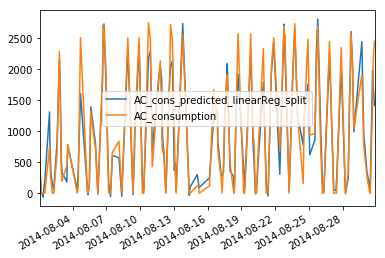

In [3]:
from sklearn import linear_model
linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train,Y_train)
predicted_linearReg_split=linear_reg.predict(X_test)

predicted_DF_linearReg_split=pd.DataFrame(predicted_linearReg_split,index=Y_test.index, columns=["AC_cons_predicted_linearReg_split"])

predicted_DF_linearReg_split=predicted_DF_linearReg_split.join(Y_test)

predicted_DF_linearReg_split_August=predicted_DF_linearReg_split["2014-08-01":"2014-08-30"]

predicted_DF_linearReg_split_August.plot()
plt.show()

In order to see from a mathematical point the view how our prediction is valid, we calculate the Mean squared error, Mean absolute error and the accuracy.

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
MAE_linearReg_split=mean_absolute_error(predicted_linearReg_split,Y_test)
MSE_linearReg_split=mean_squared_error(predicted_linearReg_split,Y_test)
r2_linearReg_split=r2_score(predicted_linearReg_split,Y_test)
print("The accuracy is the "+ str(r2_linearReg_split*100) + "%")

The accuracy is the 87.6097805082%


The second method used for the prediction is the so called "K-fold Cross Validation". With this methods we takes a sets of data divided in samples. With a cycle, at each iteration, a sample is used as a test, and the others as a train, the cycle stop when all the samples are used as test and train. This method is used in order to "better train" the model, avoiding problems of overfitting, and so improving the accuracy of the predictions.

In [5]:
from sklearn.model_selection import cross_val_predict

predict_DF_linearReg_CV = cross_val_predict(linear_reg,DF_features, DF_target, cv=10)
predicted_DF_linearReg_CV=pd.DataFrame(predict_DF_linearReg_CV,index=DF_target.index, columns=["AC_cons_predicted_linearReg_CV"])

predicted_DF_linearReg_CV=predicted_DF_linearReg_CV.join(DF_target)

predicted_DF_linearReg_CV.plot()


predicted_DF_linearReg_CV_August=predicted_DF_linearReg_CV["2014-08-01":"2014-08-30"]
predicted_DF_linearReg_CV_August.plot()

MAE_linearReg_CV=mean_absolute_error(predict_DF_linearReg_CV,DF_target)
MSE_linearReg_CV=mean_squared_error(predict_DF_linearReg_CV,DF_target)
r2_linearReg_CV=r2_score(predict_DF_linearReg_CV,DF_target)
print("The accuracy is the "+ str(r2_linearReg_CV*100) + "%")

The accuracy is the 87.8340716022%


Now we use the "K-fold Cross Validation" but not with a linear mathematical model, but with another one called Random Forest, which is more accurate than the linear one, but in the other hand this model gives us an higher computitional cost.

In [6]:
from sklearn.ensemble import RandomForestRegressor
reg_RF = RandomForestRegressor()

predict_RF_CV = cross_val_predict(reg_RF,DF_features, DF_target, cv=10)


predicted_DF_RF_CV=pd.DataFrame(predict_RF_CV,index=DF_target.index, columns=["AC_cons_predicted_RF_CV"])

predicted_DF_RF_CV=predicted_DF_RF_CV.join(DF_target)

predicted_DF_RF_CV.plot()


predicted_DF_RF_CV_August=predicted_DF_RF_CV["2014-08-01":"2014-08-30"]
predicted_DF_RF_CV_August.plot()

MAE_RF_CV=mean_absolute_error(predict_RF_CV,DF_target)
MSE_RF_CV=mean_squared_error(predict_RF_CV,DF_target)
r2_RF_CV=r2_score(predict_RF_CV,DF_target)
print("The accuracy is the "+ str(r2_RF_CV*100) + "%")

The accuracy is the 90.1680312507%


The last procedure showed is the most accurate and complicate to implement. Infact now we want to estabilish a period of time used as a train, and another as test. In our case the train period will be start the march's month. With a while cycle we want to make an "online prediction" infact at each iteration is predicted the next our of the the training period (i.e the first hour of april), and the training period is update with the real value of the training period. This iterations run untill the last day of september.

First of all we must define all the variables: 

DF_onlineConsumptionPrediction = is an ampty Data Frame where all the prediction will be made

period_of_training= is the Data Frame that will be contain the data train

FirstTimeStamp_measured & LastTimeStamp_measured = rappresent respectively the first and the last hour of the whole period considered

firstTimeStamp_toPredict = is the first hour to predict, which is the next hour after the priod of trainig

training_startTimeStamp & training_endTimeStamp= are the first and the last Data used to train

timeStamp_toPredict = is the first hour to predict.

Finally the DF_onlineConsumptionPrediction is changed and define as the first hour after the training period.

In [7]:
DF_onlineConsumptionPrediction = pd.DataFrame(index=DF_mod.index)
period_of_training = pd.Timedelta(30, unit="d")

FirstTimeStamp_measured = DF_mod.index[0]
LastTimeStamp_measured = DF_mod.index[-1]

firstTimeStamp_toPredict= FirstTimeStamp_measured+period_of_training

training_startTimeStamp= FirstTimeStamp_measured
training_endTimeStamp=firstTimeStamp_toPredict
timeStamp_toPredict=firstTimeStamp_toPredict

DF_onlineConsumptionPrediction=DF_onlineConsumptionPrediction.truncate(before=training_endTimeStamp)


Now the "while" cycle:
first are defined the features and the test data (as already explained), than is used the linear regression in order to make the prediction, the data predicted are added to the DF_onlineConsumptionPrediction with the real one and finally are updated the period of trainig and the next hour to predict.
Finally we can clearly see that the accuracy is increased by almost 2 % with respect to the preavious prediction model.

In [8]:
while (timeStamp_toPredict < LastTimeStamp_measured):

    DF_features_train=DF_features.truncate(before=training_startTimeStamp,after=training_endTimeStamp)
    DF_target_train= DF_target.truncate(before=training_startTimeStamp,after=training_endTimeStamp)
    
    DF_feature_test = DF_features.loc[timeStamp_toPredict].values.reshape(1,-1)
    DF_target_test=DF_target.loc[timeStamp_toPredict]
    linear_reg.fit(DF_features_train,DF_target_train)
    predicted_consumption=linear_reg.predict(DF_feature_test)
    DF_onlineConsumptionPrediction.loc[timeStamp_toPredict,"Predicted"]=predicted_consumption
    DF_onlineConsumptionPrediction.loc[timeStamp_toPredict,"Real"]=DF_target_test
    
        
    timeStamp_toPredict=timeStamp_toPredict+pd.Timedelta(1, unit="h")
    training_endTimeStamp=training_endTimeStamp+pd.Timedelta(1, unit="h")
    training_startTimeStamp=training_startTimeStamp+pd.Timedelta(1, unit="h")
    
DF_onlineConsumptionPrediction.dropna(inplace=True)
R2_score_online_linearReg=r2_score(DF_onlineConsumptionPrediction[["Real"]],DF_onlineConsumptionPrediction[["Predicted"]])
print("The accuracy is the "+ str(R2_score_online_linearReg*100) + "%")

The accuracy is the 91.5015772425%


Finaly we can make the same function but using the Random Forest,in order to improve even more the accuracy. 

N.B

The computational cost in this case is real high, it takes 10 minutes!

In [9]:
firstTimeStamp_toPredict= FirstTimeStamp_measured+period_of_training

training_startTimeStamp= FirstTimeStamp_measured
training_endTimeStamp=firstTimeStamp_toPredict
timeStamp_toPredict=firstTimeStamp_toPredict

DF_onlineConsumptionPrediction=DF_onlineConsumptionPrediction.truncate(before=training_endTimeStamp)

while (timeStamp_toPredict < LastTimeStamp_measured):

    DF_features_train=DF_features.truncate(before=training_startTimeStamp,after=training_endTimeStamp)
    DF_target_train= DF_target.truncate(before=training_startTimeStamp,after=training_endTimeStamp)
    
    DF_feature_test = DF_features.loc[timeStamp_toPredict].values.reshape(1,-1)
    DF_target_test=DF_target.loc[timeStamp_toPredict]
    reg_RF.fit(DF_features_train,DF_target_train)
    predicted_consumption=reg_RF.predict(DF_feature_test)
    DF_onlineConsumptionPrediction.loc[timeStamp_toPredict,"Predicted"]=predicted_consumption
    DF_onlineConsumptionPrediction.loc[timeStamp_toPredict,"Real"]=DF_target_test
    
        
    timeStamp_toPredict=timeStamp_toPredict+pd.Timedelta(1, unit="h")
    training_endTimeStamp=training_endTimeStamp+pd.Timedelta(1, unit="h")
    training_startTimeStamp=training_startTimeStamp+pd.Timedelta(1, unit="h")
    
DF_onlineConsumptionPrediction.dropna(inplace=True)
R2_score_online_linearReg=r2_score(DF_onlineConsumptionPrediction[["Real"]],DF_onlineConsumptionPrediction[["Predicted"]])
print("The accuracy is the "+ str(R2_score_online_linearReg*100) + "%")

The accuracy is the 98.2653710979%
